# Median + IQR SHAP Networks

This notebook implements robust aggregation using median and interquartile range (IQR) for uncertainty quantification.

**Approach:** Use median instead of mean for aggregation (robust to outliers) and compute IQR to quantify variability/uncertainty in feature importance across patients. This provides both a robust summary and uncertainty bounds.

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

## Build Median-Based SHAP Values (psi_1)

In [4]:
shap_values_clean = np.nan_to_num(shap_values)
n_features = shap_values_clean.shape[1]

# Calculate median SHAP values across patients
median_shap = np.median(shap_values_clean, axis=0)

# Calculate IQR (25th to 75th percentile)
q25_shap = np.percentile(shap_values_clean, 25, axis=0)
q75_shap = np.percentile(shap_values_clean, 75, axis=0)
iqr_shap = q75_shap - q25_shap

# Calculate absolute median for normalization
sum_abs_median_shap = np.sum(np.abs(median_shap))

# Build psi matrices
psi_1_median = pd.DataFrame()
psi_1_median['value'] = median_shap / sum_abs_median_shap
psi_1_median['iqr'] = iqr_shap / sum_abs_median_shap
psi_1_median['q25'] = q25_shap / sum_abs_median_shap
psi_1_median['q75'] = q75_shap / sum_abs_median_shap
psi_1_median['cv'] = iqr_shap / (np.abs(median_shap) + 1e-10)  # Coefficient of variation
psi_1_median.set_index(X_shapley.columns, inplace=True)

print("Median-based node weights (psi) with uncertainty:")
print(psi_1_median.head(10))

Median-based node weights (psi) with uncertainty:
                                        value       iqr       q25       q75  \
sex_isFemale                        -0.116080  0.287531 -0.144984  0.142547   
age                                 -0.569922  1.697343 -1.063635  0.633708   
physical_activity                   -0.029620  0.082750 -0.036400  0.046349   
serum_albumin                       -0.025356  0.069424 -0.031790  0.037634   
alkaline_phosphatase                 0.002254  0.005989  0.000036  0.006025   
alkaline_phosphatase_isUnacceptable -0.000009  0.000505 -0.000021  0.000484   
alkaline_phosphatase_isTestnotdone  -0.000028  0.000070 -0.000087 -0.000016   
SGOT                                -0.003781  0.003800 -0.005064 -0.001263   
SGOT_isUnacceptable                 -0.000242  0.000092 -0.000290 -0.000198   
SGOT_isTestnotdone                  -0.000033  0.000013 -0.000037 -0.000025   

                                            cv  
sex_isFemale                   

## Build Median-Based Interaction Values (r_1)

In [5]:
# Remove diagonal
n_variables = shap_interaction_values.shape[1]
filtered_shap_interaction_values = np.nan_to_num(shap_interaction_values.copy())
idx_patients = np.repeat(np.arange(num_patients), n_variables)
idx_variables = np.tile(np.arange(n_variables), num_patients)
filtered_shap_interaction_values[idx_patients, idx_variables, idx_variables] = 0

# Calculate median interaction values across patients
median_interaction = np.median(filtered_shap_interaction_values, axis=0)

# Calculate IQR for interactions
q25_interaction = np.percentile(filtered_shap_interaction_values, 25, axis=0)
q75_interaction = np.percentile(filtered_shap_interaction_values, 75, axis=0)
iqr_interaction = q75_interaction - q25_interaction

# Normalize
sum_abs_median_interaction = np.sum(np.abs(median_interaction))

# Build r_1 with uncertainty
r_1_median = pd.DataFrame(median_interaction / sum_abs_median_interaction)
r_1_median.rename(columns=dict(list(zip(r_1_median.columns, X_shapley.columns))), inplace=True)
r_1_median.set_index(X_shapley.columns, inplace=True)

# Store IQR separately
r_1_iqr = pd.DataFrame(iqr_interaction / sum_abs_median_interaction)
r_1_iqr.rename(columns=dict(list(zip(r_1_iqr.columns, X_shapley.columns))), inplace=True)
r_1_iqr.set_index(X_shapley.columns, inplace=True)

print(f"\nMedian-based edge weights (r) computed")
print(f"Mean IQR for interactions: {iqr_interaction.mean():.6f}")


Median-based edge weights (r) computed
Mean IQR for interactions: 0.000136


In [6]:
# Store Q25 and Q75 for interactions
r_1_q25 = pd.DataFrame(q25_interaction / sum_abs_median_interaction)
r_1_q25.rename(columns=dict(list(zip(r_1_q25.columns, X_shapley.columns))), inplace=True)
r_1_q25.set_index(X_shapley.columns, inplace=True)

r_1_q75 = pd.DataFrame(q75_interaction / sum_abs_median_interaction)
r_1_q75.rename(columns=dict(list(zip(r_1_q75.columns, X_shapley.columns))), inplace=True)
r_1_q75.set_index(X_shapley.columns, inplace=True)

print(f"Q25 and Q75 dataframes created for interactions")

Q25 and Q75 dataframes created for interactions


## Normalize Matrices

In [7]:
# Create psi_1 with just the value column for normalization
psi_1 = psi_1_median[['value']].copy()
psi_2 = normalize_psi(psi_1)
r_2 = normalize_r(r_1_median)

c:\Workspace\IJAR\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization

In [8]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

In [9]:
positive_color

(np.float64(0.0),
 np.float64(0.5433775692459109),
 np.float64(0.983379062301401))

C:\Users\secci\AppData\Local\Temp\ipykernel_6760\1509097954.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(filter_edge)
C:\Users\secci\AppData\Local\Temp\ipykernel_6760\1509097954.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adjacency = r.copy().applymap(lambda x: 1 if x != 0 else 0)


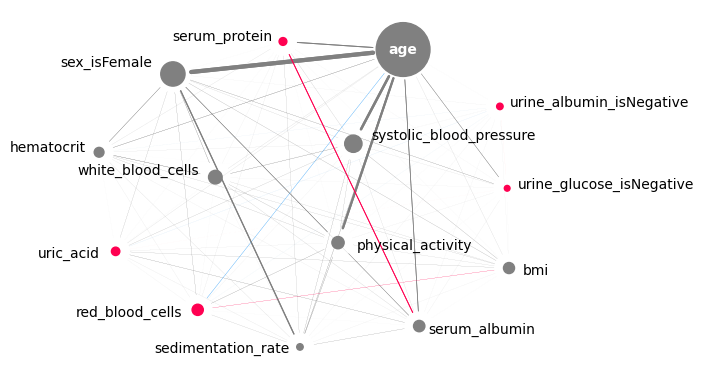

In [14]:
draw(
    psi=psi_2,
    r=r_2,
    psi_q25=psi_1_median,
    psi_q75=psi_1_median,
    r_q25=r_1_q25,
    r_q75=r_1_q75,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
    uncertain_color='grey'
)